In [1]:
#IBM notebook style
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

# IBM Quantum signature learning asset for forecasting

As part of the IBM Quantum forecasting educational asset, quantum support vector regression (QSVR) is used for time series forecasting. In this notebook, QSVR is compared with SVR forecasting to provide a like-for-like comparison. In a business setting, QSVR would be added to the forecasting toolbox, increasing the variety of tools and potentially improving the accuracy of a subset of business forecasts.

## Quantum support vector regression

QSVR is a quantum-enhanced version of the SVR algorithm.<sup>1</sup> It is quantum-enhanced in the same way as QSVC, in that it utilizes quantum kernel estimation (QKE) (see module 2). This means the classical SVR algorithm makes calls to a quantum kernel function that is implemented in a quantum circuit that can be run on an IBM quantum computer or simulated on a classical computer. In QSVR, the SVR algorithm aims to fit a regression hyperplane to quantum feature vectors in a nonlinear, higher-dimensional feature space, which in QSVR is an exponentially larger quantum Hilbert space of size $2^n$.

The difference between the SVR and SVC algorithms is the regression cost function and constraints, which take a similar form but with important differences. In the SVR algorithm used for QSVR, the $\varepsilon$ hyperparameter sets the size of the $\varepsilon$-tube that surrounds the predicted values of the regression hyperplane and ensures only data points outside the $\varepsilon$-tube are penalized by the slack variables $\zeta_i$,$\zeta^*_i$. The hyperpameter $C$ controls the strength of these penalties as a regularization parameter. The primal cost function is:

\begin{equation}
\min_{w ,b ,\zeta, \zeta^*} \; {\textstyle{\frac{1}{2}}} \|\bar{w}\|^2 + C \sum_{i=1}^{n} (\zeta_i + \zeta^*_i)
\end{equation}
subject to constraints
\begin{equation}
y_i - (\bar{w} \cdot \bar{\phi}(x_i) + b) \leq \varepsilon + \zeta_i,\\(\bar{w} \cdot \bar{\phi}(x_i) + b) - y_i \leq \varepsilon + \zeta_i^* \\ \zeta_i,\zeta_i^* \geq 0,\; i=1,\dots,n.
\end{equation}

The dual cost function for QSVR in vector form uses the quantum kernel function to compute the matrix elements $Q_{i,j} = K(x_i,x_j) = |\langle \Phi(x_i)|\Phi(x_j)\rangle|^2$.

\begin{equation}
\min_{\alpha,\alpha^*} \; \textstyle{\frac{1}{2}} \left[\bar{\alpha}-\bar{\alpha}^*\right]^T Q \left[\bar{\alpha} - \bar{\alpha}^*\right] + \varepsilon \bar{e}^T \left[\bar{\alpha}+\bar{\alpha}^*\right]-\bar{y}^T \left[\bar{\alpha} - \bar{\alpha}^*\right]
\end{equation}
subject to constraints
\begin{equation}
\textstyle\bar{e}^T \left[\bar{\alpha} - \bar{\alpha}^*\right] = 0 \\ 0 \leq \alpha_i, \alpha^*_i \leq C,\; i=1,\dots,n
\end{equation}

where $\bar{e}$ is an all-ones vector. Once the regression model is trained, it takes the form $\sum_{i \in SV}(a_i - a_i^*)K(x_i,x) + b$, over support vectors $SV$, where the quantum kernel function $K(x_i,x_j)$ is called to compute feature space inner products between test data $x$ and support vectors $x_i$.

In [`scikit-learn`](https://scikit-learn.org/stable/modules/svm.html#svm-regression) in Python the ```SVR``` class is ideally suited for our purposes because it allows the use of a custom kernel function as a callable function. This is how the quantum kernel function from Qiskit is called by ```SVR```. We do not use the ```precompute``` argument for explicitly precomputed Gram matrices.

## Forecasting and the chaining method

Using a supervised regressor, in this case QSVR, the chaining method involves first preparing training data as a number of consecutive data points in a time series, $y_1,y_2,\dots,y_n$, giving a window of size $n$ as an $n$-dimensional data vector, where the target data point is the next data point in the time series $y_{n+1}$. Then the next row of predictors is $y_2,y_3,\dots,y_{n+1}$ with target $y_{n+2}$. The figure below shows training data prepared in this way for $n=3$. The testing data is prepared in the same way.

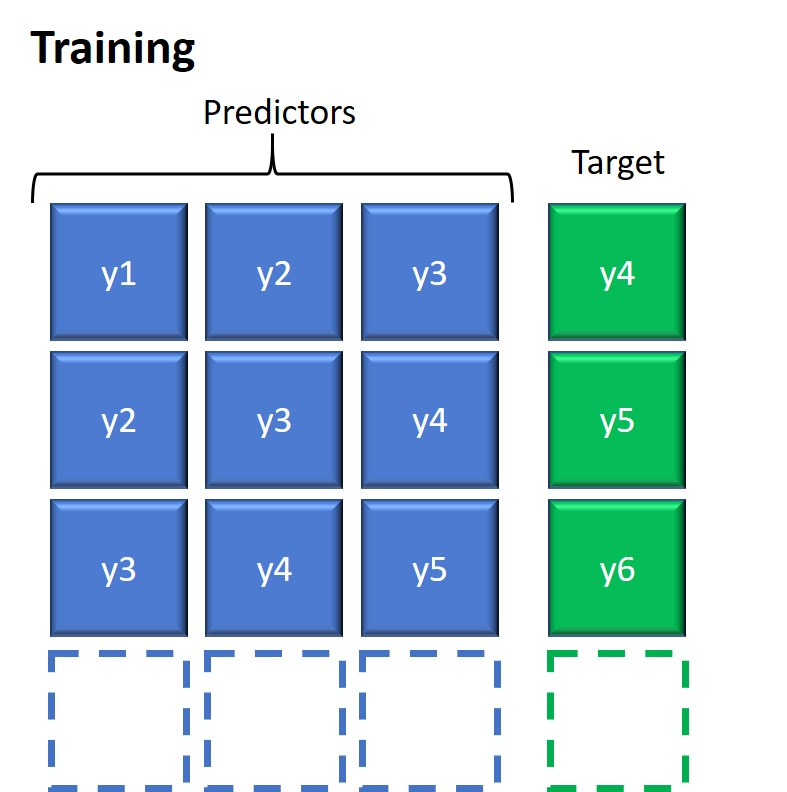

In [2]:
from IPython.display import Image
Image("figs/Preparing training data.jpg", width=300)

QSVR is trained on this data for time series forecasting. The size of the window is equal to the number of qubits in the quantum kernel circuit. 

Once QSVR is trained, the model is ready for forecast prediction on test data. The figure below shows forecasting one and two time steps ahead, where the one-step-ahead prediction is incorporated into the end of the window for the two-step-ahead forecast. The error for the second-step-ahead forecast is larger than the first.

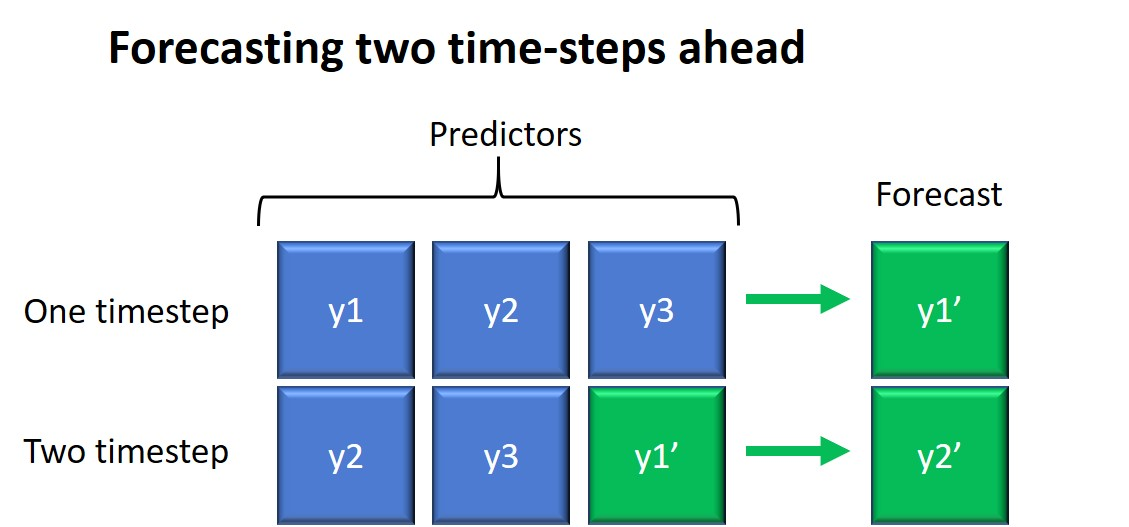

In [3]:
Image("figs/forecasting figure.jpg", width=450)

When performing a train-test split with this data, it should be done as follows:

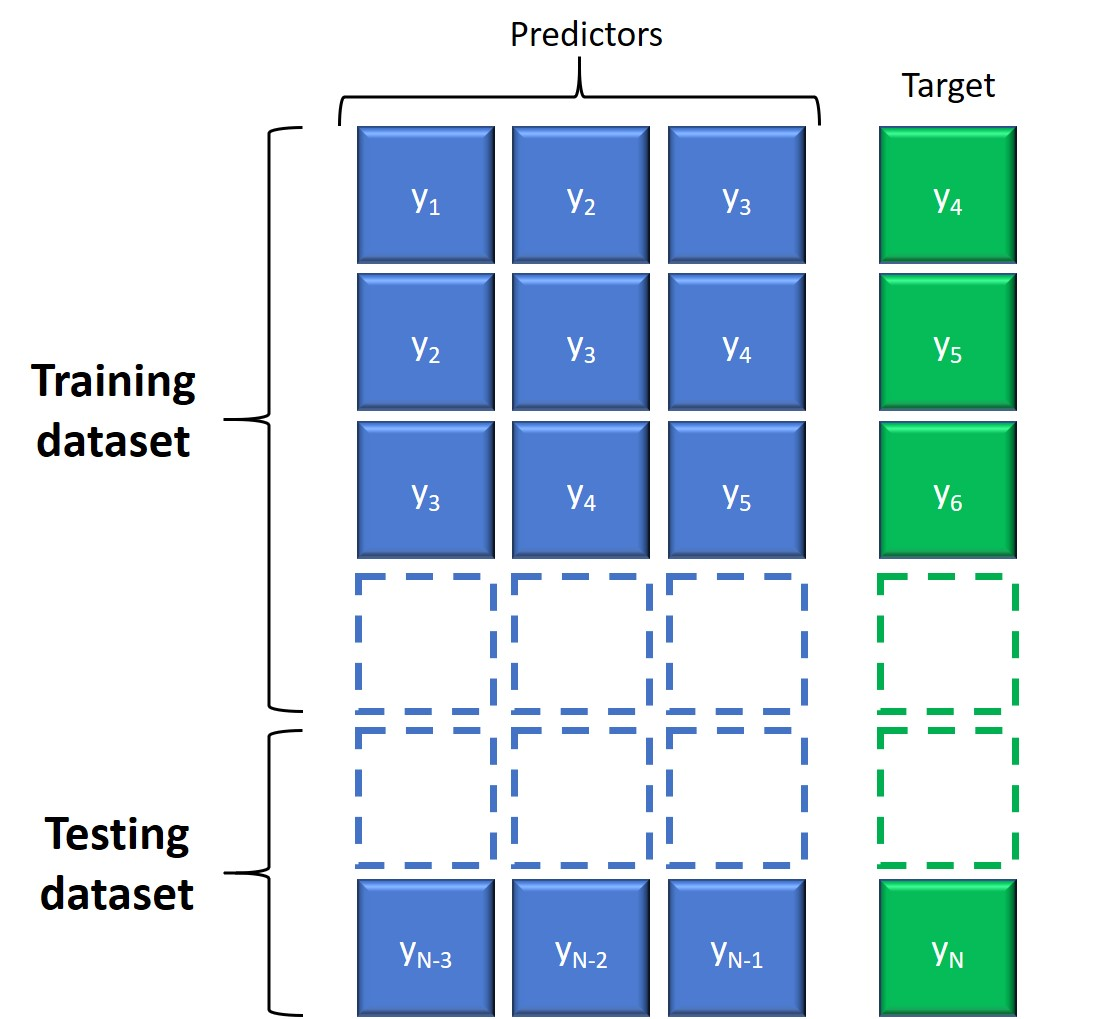

In [4]:
Image("figs/train-test split figure.jpg", width=400)

In [5]:
"""
@author: DanielFry

MAPE forecast error metric
MASE forecast error metric
"""
import numpy as np
from sklearn.metrics import mean_absolute_error


def mape_metric(y_true, y_pred):
    # check arrays have the same length
    assert y_true.shape[0] == y_pred.shape[0]
    # reshape arrays to make sure they're the same shape
    y_true = y_true.reshape((-1, 1))
    y_pred = y_pred.reshape((-1, 1))
    # return MAPE calculation
    return (np.sum(np.abs((y_true - y_pred)/y_true))) / y_true.shape[0]


def mase_metric(onestep_ahead_model,
                twostep_ahead_model,
                y_true):
    '''
    MASE is a forecasting metric with good properties like being scale
    independent, symmetric and interpretable.

    MASE = MAE(error) / MAE(Naive forecast)
    https://en.wikipedia.org/wiki/Mean_absolute_scaled_error

    MASE is the MAE of a given model predictions divided by and the MAE of
    the Naive model predictions.

    Note: This means that the arrays have to be shortened because the first
    value in the y_true array can't be predicted by the Naive model from the
    given input arrays.

    A MASE value less than 1 means the given model performs better than the
    Naive forecast model.
    A MASE value equal to 1 means the given model performs equal to the Naive
    forecast model.
    A MASE value of greater than 1 means the given model performs worse than
    the Naive forecast model.

    The input arrays need to be shortened to make them the same length as the
    naive model forecast arrays which require one and two lead values from the
    input array.
    '''
    # Make sure the lengths of input arrays are what is expected
    assert len(onestep_ahead_model) == len(twostep_ahead_model) + 1
    assert len(onestep_ahead_model) == len(y_true)

    def naive_forecast_2step(y_true):
        '''
        Naive forecast propagates values 2 steps ahead.
        -
        Returns a RxC = (n-1)x2 array, containing (n-1) rows and 2 cols for
        the 2 timesteps ahead.
        '''
        y_true = y_true.reshape((-1, 1))        # Uses correct shape
        y_temp = np.hstack((y_true, y_true))    # Duplicates col
        y_pred = y_temp[:-1, :]                 # Removes last row
        return y_pred

    # Extract arrays from naive_forecast_2step output
    onetwo_naive_forecast = naive_forecast_2step(y_true)
    onestep_ahead_naive = onetwo_naive_forecast[:, 0]
    twostep_ahead_naive = onetwo_naive_forecast[:-1, 1]

    # Ensure array shapes are the same for further calculations
    onestep_ahead_naive = onestep_ahead_naive.reshape(-1,)
    twostep_ahead_naive = twostep_ahead_naive.reshape(-1,)
    onestep_ahead_model = onestep_ahead_model.reshape(-1,)
    twostep_ahead_model = twostep_ahead_model.reshape(-1,)
    y_true = y_true.reshape(-1,)

    # shorten input arrays from the front - see MASE docstring
    onestep_ahead_model = onestep_ahead_model[1:]
    twostep_ahead_model = twostep_ahead_model[1:]
    y_true = y_true[1:]

    # one and two step ahead y_true
    y_true_long = np.concatenate((y_true, y_true[1:]))

    # one and two step ahead naive forecast
    # MAE for naive forecasts
    onetwo_ahead_naive = np.concatenate((onestep_ahead_naive,
                                         twostep_ahead_naive))
    mae_naive = mean_absolute_error(y_true_long, onetwo_ahead_naive)

    # one and two step ahead model forecasts
    # MAE for model forecasts
    onetwo_ahead_model = np.concatenate((onestep_ahead_model,
                                         twostep_ahead_model))
    mae_model = mean_absolute_error(y_true_long, onetwo_ahead_model)

    # MASE
    mase = mae_model/mae_naive
    return mase


def mase_metric_1ahead(y_true, onestep_ahead_model):
    # Make sure the lengths of input arrays are what is expected
    assert len(onestep_ahead_model) == len(y_true)

    def naive_forecast_1step(y_true):
        y_true = y_true.reshape((-1, 1))     # Uses correct shape
        y_pred = y_true[:-1]                 # Removes last element
        return y_pred

    # Extract arrays from naive_forecast_1step output
    onestep_ahead_naive = naive_forecast_1step(y_true)

    # Ensure array shapes are the same for further calculations
    onestep_ahead_naive = onestep_ahead_naive.reshape(-1,)
    onestep_ahead_model = onestep_ahead_model.reshape(-1,)
    y_true = y_true.reshape(-1,)

    # shorten input arrays from the front - see MASE docstring
    onestep_ahead_model = onestep_ahead_model[1:]
    y_true = y_true[1:]

    mae_naive = mean_absolute_error(y_true, onestep_ahead_naive)
    mae_model = mean_absolute_error(y_true, onestep_ahead_model)

    # MASE
    mase = mae_model/mae_naive
    return mase

## QSVR forecasting

First, let’s consider a top-level summary of the code below for QSVR forecasting. In this code, there are three time series available for QSVR forecasting using either $Z$ or $ZZ$ feature maps (see module 2, “Quantum feature maps”). The optimal SVR hyperparameters $\{C, \varepsilon\}$ were preselected in a grid search based on the mean absolute scaled error (MASE).<sup>2</sup> See the end of this notebook for a note on the MASE metric. For the purposes of this demo, the time-step lag or window was also treated as a simple hyperparameter.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityStatevectorKernel 

In [7]:
# Choose product key from product_dict:
product_string = "Prod 26"

product_dict = {"Prod 1287": "Product_1287_WHJ",
                "Prod 3": "Product_0003_WHJ",
                "Prod 26": "Product_0026_WHJ"}

product_header = product_dict[product_string]

df = pd.read_csv('data/qdata.csv', usecols=[product_header])
y = df.values
X = np.arange(len(y))  # using integers instead of dates

In the cell above, select a string for a product from the ```product_dict``` keys and assign it to ```product_string```. The time series will be loaded from the `qdata.csv` file.

The following code cell defines four functions: ```timeseries_split``` to split the data into training and testing data, ```prepare_lag_data``` to structure training data, ```forecast_2steps_over_array``` to forecast by the chaining method, and ```metrics_dict``` to calculate four metrics for forecasting performance.

In [8]:
def timeseries_split(array, train_percent_split):
    len_array = len(array)
    split_index = int(round(train_percent_split*len_array))
    train_array = array[:split_index]
    test_array = array[split_index:]
    return train_array, test_array


def prepare_lag_data(y, lag):
    '''
    Prepares feature data. Number of time steps = lag
    Returns tuple of feature data and y target data
    '''
    data = []
    for i,v in enumerate(y):
        row = []
        for j in range(lag):
            row.append(y[i+j][0])
        data.append(row)
        if i > len(y) - (lag+1):
            break
    return np.array(data[:-1]), y[lag:]


def forecast_2steps_over_array(model, y_true, features):
    '''
    This code only predicts two timesteps ahead.
    
    After the model has been trained, this code forecasts future data
    by chaining predictions using constant number of predictors.
    '''
    # one step ahead predictions
    one_ahead_preds = model.predict(features).reshape((-1,1))
    # create new feature array including one-ahead predictions
    new_feats = np.concatenate((features[:,1:], one_ahead_preds), axis=1)
    # make predictions from new feature array
    new_preds = model.predict(new_feats).reshape((-1,1))
    # return one-ahead and two-ahead predictions array
    return np.concatenate((one_ahead_preds, new_preds), axis=1)


def metrics_dict(y_true, y_pred):
    
    metrics = {'RMSE': np.sqrt(mean_squared_error(y_true,y_pred)),
               'MAPE': mape_metric(y_true,y_pred),
               'MAE': mean_absolute_error(y_true, y_pred),
               }

    mase = mase_metric(one_ahead_test_pred,
                       two_ahead_test_pred[:, 1][:-1],
                       y_test)
    metrics.update({'MASE': mase})
    return metrics

In [9]:
# store optimal hyperparams for each timeseries and feature map in dict
param_dict_Product_1287 = {'ZZFM optimal params': {'lag': 6, 'C': 777778, 'epsilon': 0.0, 'reps': 5},
                           'ZFM optimal params': {'lag': 4, 'C': 622222.222222, 'epsilon': 2.122222, 'reps': 5}}
param_dict_Product_26 = {'ZZFM optimal params': {'lag': 6, 'C': 34000.0, 'epsilon': 0.0, 'reps': 4},
                         'ZFM optimal params': {'lag': 8, 'C': 5789.473684, 'epsilon': 4.210526, 'reps': 4}}
param_dict_Product_3 = {'ZZFM optimal params': {'lag': 4, 'C': 1e5, 'epsilon': 1e1, 'reps': 3},
                        'ZFM optimal params': {'lag': 4, 'C': 15263.157895, 'epsilon': 1.105263, 'reps': 4}}

main_param_dict = {"Prod 1287": param_dict_Product_1287,
                   "Prod 26": param_dict_Product_26,
                   "Prod 3": param_dict_Product_3}

The dictionary ```main_param_dict``` above contains optimal hyperparameters previously determined by a grid search for three time series. 

The following code first performs a train-test split of the data with ```timeseries_split```, then prepares the data for forecasting with ```prepare_lag_data```. Following this, a feature map is created depending on the given ```parameters_string```, and finally an instance of the ```FidelityStatevectorKernel``` class from Qiskit is created.

Assign either ```'ZFM optimal params'``` or ```'ZZFM optimal params'``` to ```parameters_string``` below for the $Z$ or $ZZ$ feature map kernel and associated optimal hyperparameters.

ZZFM optimal params


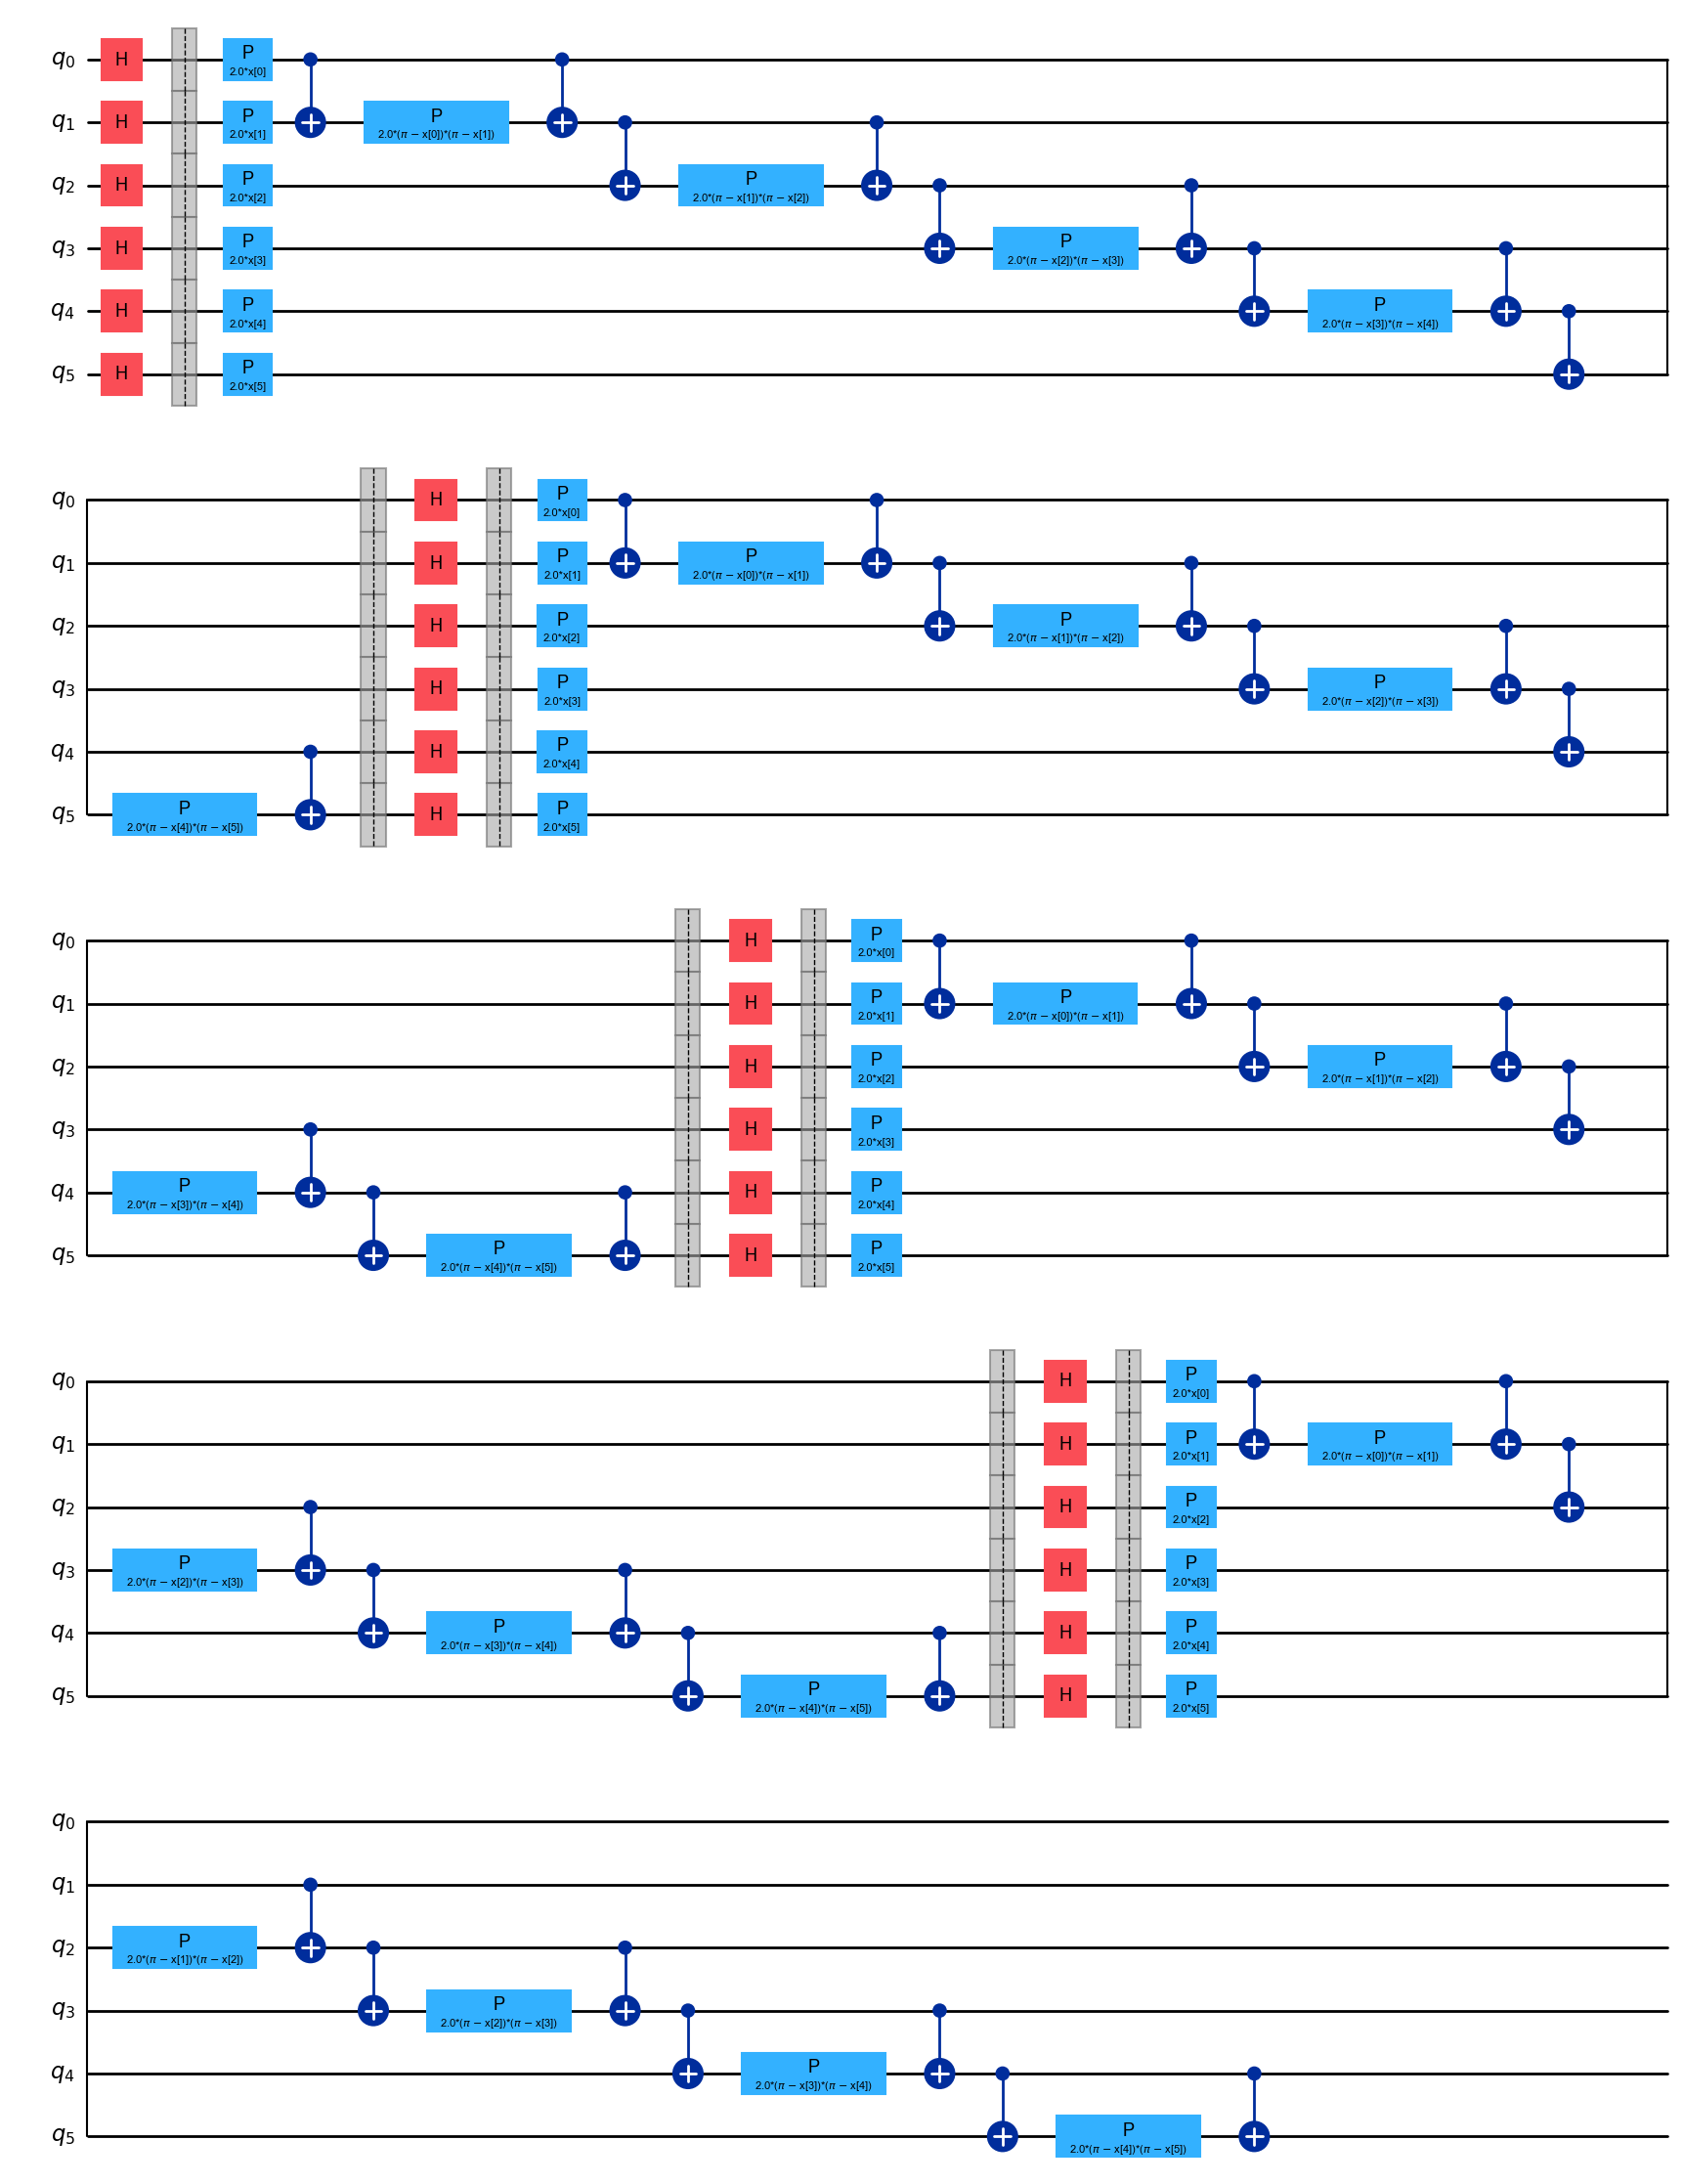

In [10]:
# Choose parameters_string for kernel type and optimal hyperparams
parameters_string = 'ZZFM optimal params'
param_dict = main_param_dict[product_string][parameters_string]

# parameters contained in param_dict
# can be changed to different values
lag = param_dict['lag']
reps = param_dict['reps']    # feature map repetitions
C = param_dict['C']          # SVR hyperparameter
eps = param_dict['epsilon']  # SVR hyperparameter

# lag_split_dict holds train-test split proportions for each lag key
# to maintain a good test set size and consistent size across all lags
lag_split_dict = {2: 0.86, 3: 0.85, 4: 0.84, 5: 0.82, 6: 0.80, 7: 0.78, 8: 0.76, 9: 0.75, 10: 0.73, 11: 0.71}
y_train_split, y_test_split = timeseries_split(y, lag_split_dict[lag])

num_features = lag
features_train, y_train = prepare_lag_data(y_train_split, num_features)
features_test, y_test = prepare_lag_data(y_test_split, num_features)

# QUANTUM FEATURE MAP
if parameters_string == 'ZFM optimal params':
    feature_map = ZFeatureMap(feature_dimension=num_features, reps=reps, insert_barriers=True)
elif parameters_string == 'ZZFM optimal params':
    feature_map = ZZFeatureMap(feature_dimension=num_features, reps=reps, entanglement='linear', insert_barriers=True)
else:
    raise ValueError('Unknown parameters_string')

# quantum kernel
quantum_kernel = FidelityStatevectorKernel(feature_map=feature_map)

# print feature map
print(parameters_string)
from qiskit.visualization import circuit_drawer
circuit_drawer(feature_map.decompose(), output='mpl', scale = 1)

The code below fits a QSVR forecasting model. Predictions are made one time step ahead on the training data, and one and two time steps ahead on the testing data. Forecasting performance metrics are calculated.

In [11]:
qsvr = SVR(kernel=quantum_kernel.evaluate, C=C, epsilon=eps)
qsvr.fit(features_train, y_train)

one_ahead_train_pred = qsvr.predict(features_train)

two_ahead_test_pred = forecast_2steps_over_array(model=qsvr, y_true=y_test, features=features_test)
one_ahead_test_pred = two_ahead_test_pred[:,0]

metrics = metrics_dict(np.concatenate((y_test, y_test[1:])),
                       np.concatenate((one_ahead_test_pred, two_ahead_test_pred[:,1][:-1])))

In [12]:
def plot_train_test_forecasts():
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,5))
    f.suptitle(f"QSVR forecast for {product_string} with {parameters_string}")
    ax1.set_title('Training set')
    ax1.plot(X[:len(y_train_split)], y_train_split,marker='o')
    ax1.plot(X[lag:len(y_train)+lag], one_ahead_train_pred, linewidth=7.0, alpha=0.5,marker='o')
    ax2.set_title('Forecast test set')
    ax2.plot(X[-len(y_test_split):], y_test_split,marker='o')
    ax2.plot(X[len(y_train)+lag+lag:], one_ahead_test_pred, linewidth=7.0, alpha=0.5,marker='o')
    ax2.plot(X[len(y_train)+lag+lag+1:], two_ahead_test_pred[:,1][:-1], linewidth=6.0, alpha=0.6,marker='o')


def print_all_metrics(dictionary):
    print('1 and 2 steps ahead forecast metrics\n')
    for k in dictionary.keys():
        print(f'{k}:\t{dictionary[k]:.2f}')

1 and 2 steps ahead forecast metrics

RMSE:	2291.42
MAPE:	2.05
MAE:	1848.19
MASE:	0.41


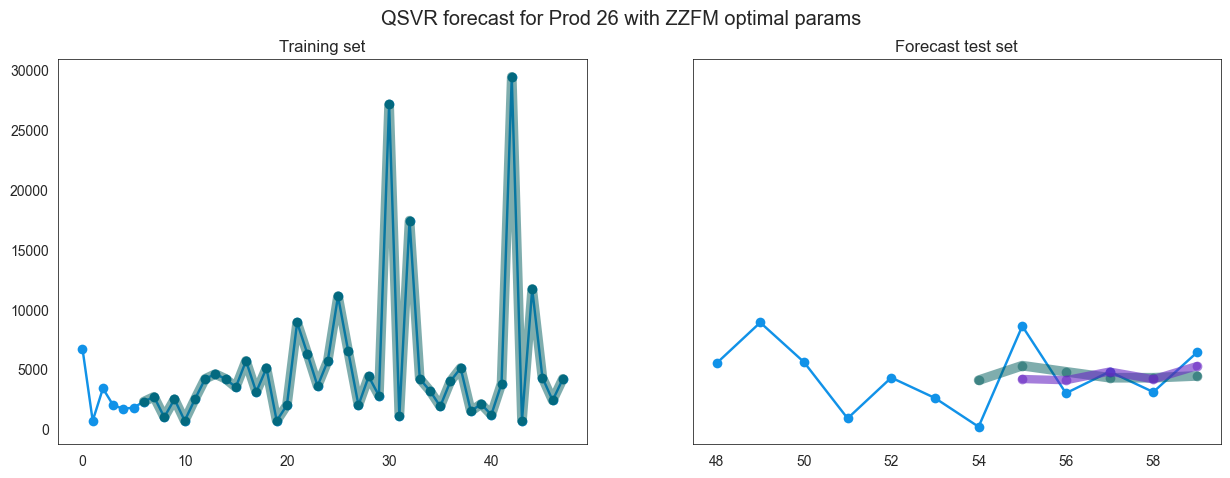

In [13]:
plot_train_test_forecasts()
print_all_metrics(metrics)

The `Training set` plot on the left-hand side shows the training time series data and one-step-ahead forecast. 

The `Forecast test set` plot on the right-hand side shows the test time series data with one- and two-step-ahead forecasts in green and black, respectively. The Y-axis is shared by the two plots. The smaller the error between the forecasts and the test data, the better the forecast performance. The unforecasted data at the beginning of the time series shows the number of data points in the window required to make an initial forecast. Then, forecasts are subsequently made by running forward over the data in a stepwise fashion to give six one-step-ahead forecasts (green) and five two-step-ahead forecasts (black).

The code above is run again with ```parameters_string = 'ZFM optimal params'``` to produce the following result.

1 and 2 steps ahead forecast metrics

RMSE:	2291.42
MAPE:	2.05
MAE:	1848.19
MASE:	0.41


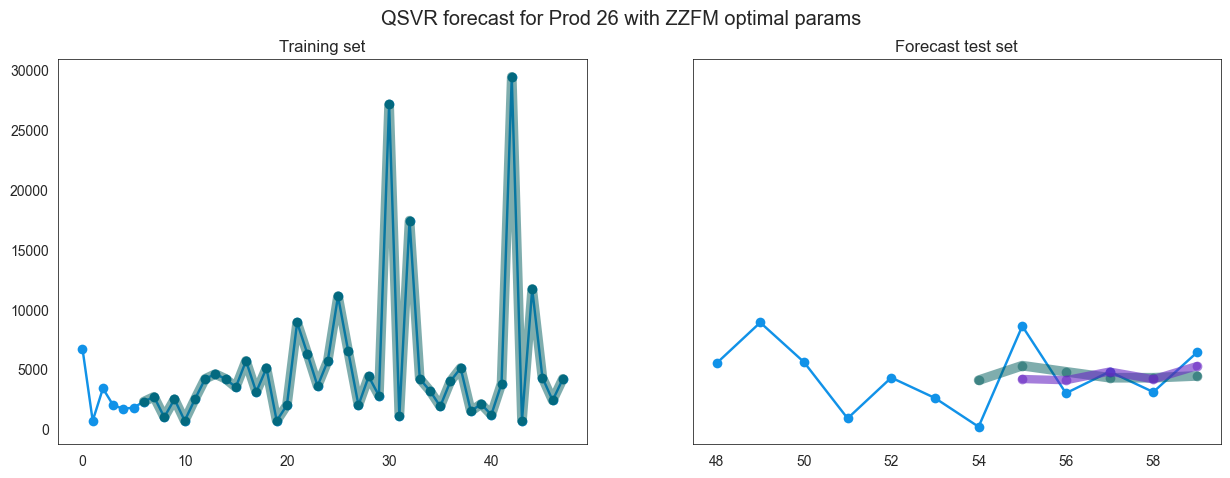

In [14]:
plot_train_test_forecasts()
print_all_metrics(metrics)

For Product 26, QSVR with ZZFM has marginally better performance, while for Product 3 and Product 1287 the ZFM feature map had better performance. It is hypothesized that the ZZFM-based kernel is a “non-trivial” feature map that can’t be computed efficiently on a classical computer<sup>3</sup> and thus has a potential for quantum advantage should such a complex model be required for a larger data set. On the other hand, it is known that a ZFM-based kernel can be computed efficiently on a classical computer and therefore represents a feasible classical model.

QSVR with Z and ZZFM kernels tends to overfit in spite of being optimized for test data. 

## SVR forecasting

In this part of the notebook, SVR forecasting is implemented in the same way as was done for QSVR above.

As opposed to QSVR, a classical kernel function called the Gaussian radial basis function (RBF) is used and selected by ```SVR(kernel='rbf',...)```. Other kernels can be selected.

In [15]:
# store hyperparams and lags in a dictionary here for optimal and lag, alternate lag, and ZZFM and ZFMs.
param_dict_Product_1287 = {'lag': 3, 'C': 33.4333, 'epsilon': 0.0, 'gamma': 1e-2}
param_dict_Product_26 = {'lag': 8, 'C': 33.4333, 'epsilon': 0.0, 'gamma': 1e-2}
param_dict_Product_3 = {'lag': 8, 'C': 850, 'epsilon': 3e-2, 'gamma': 1e-2}

svr_main_param_dict = {"Prod 1287": param_dict_Product_1287,
                       "Prod 26": param_dict_Product_26,
                       "Prod 3": param_dict_Product_3}

In [16]:
lag = svr_main_param_dict[product_string]['lag']
C = svr_main_param_dict[product_string]['C']
eps = svr_main_param_dict[product_string]['epsilon']
gamma = svr_main_param_dict[product_string]['gamma']

# lag determines the number of features
num_features = lag
lag_split_dict = {2: 0.86, 3: 0.85, 4: 0.84, 5: 0.82, 6: 0.80, 7: 0.78, 8: 0.76, 9: 0.75, 10: 0.73, 11: 0.71}
y_train_split_orig, y_test_split_orig = timeseries_split(y, lag_split_dict[lag])

# minmaxscale data
scaler = MinMaxScaler()
scaler.fit(y_train_split_orig)
y_train_split = scaler.transform(y_train_split_orig)
y_test_split = scaler.transform(y_test_split_orig)

features_train, y_train = prepare_lag_data(y_train_split, num_features)

# Instantiate and fit model
C, eps, gamma = 33.4333, 0.0, 1e-2
svr = SVR(kernel='rbf', C=C, epsilon=eps, gamma=gamma)
svr.fit(features_train, y_train)

one_ahead_train_pred = svr.predict(features_train)     # one-ahead predictions on train data

features_test, y_test = prepare_lag_data(y_test_split, num_features)
one_ahead_test_pred = svr.predict(features_test)       # one-ahead predictions on test data

In [17]:
#two_ahead_train_pred = forecast_2steps_over_array(model=svr, y_true=y_train, features=features_train)
two_ahead_test_pred = forecast_2steps_over_array(model=svr, y_true=y_test, features=features_test)

# inverse minmaxscale
one_ahead_train_pred = one_ahead_train_pred.reshape(-1,1)
one_ahead_test_pred = one_ahead_test_pred.reshape(-1,1)
one_ahead_train_pred = scaler.inverse_transform(one_ahead_train_pred).reshape(-1,1)
one_ahead_test_pred = scaler.inverse_transform(one_ahead_test_pred).reshape(-1,1)
two_ahead_test_pred = scaler.inverse_transform(two_ahead_test_pred)
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)


#one_ahead_train_pred_metrics = metrics_dict(y_train, one_ahead_train_pred)
#one_ahead_test_pred_metrics = metrics_dict(y_test, one_ahead_test_pred)
one_ahead_test_pred = two_ahead_test_pred[:,0]
metrics = metrics_dict(np.concatenate((y_test, y_test[1:])),
                       np.concatenate((one_ahead_test_pred, two_ahead_test_pred[:,1][:-1])))

1 and 2 steps ahead forecast metrics

RMSE:	2276.23
MAPE:	1.81
MAE:	1655.97
MASE:	0.35


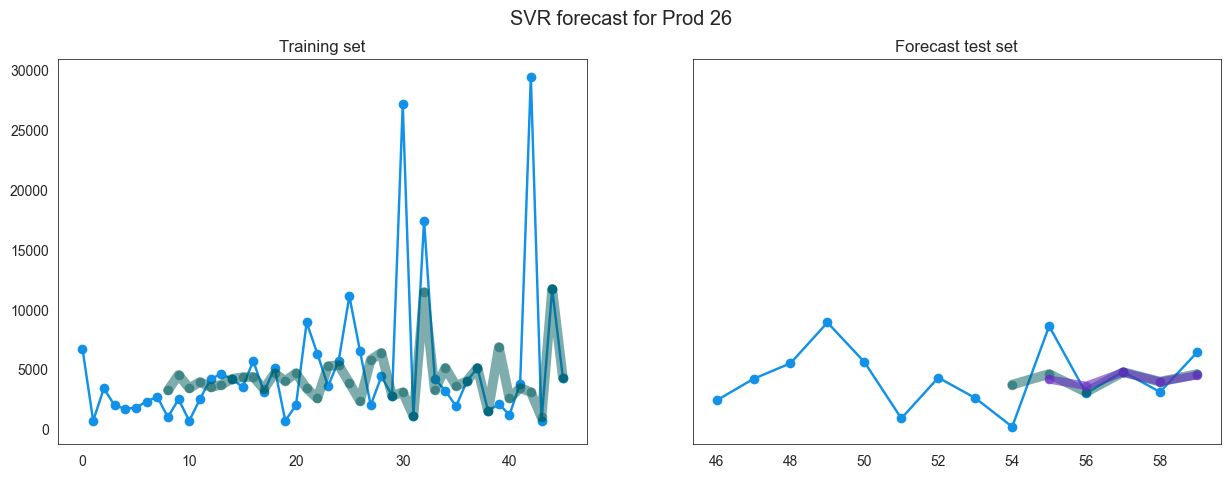

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,5))
f.suptitle(f"SVR forecast for {product_string}")
ax1.set_title('Training set')
ax1.plot(X[:len(y_train_split_orig)], y_train_split_orig, marker='o')
ax1.plot(X[lag:len(y_train)+lag], one_ahead_train_pred, linewidth=7.0, alpha=0.5, marker='o')
ax2.set_title('Forecast test set')
ax2.plot(X[-len(y_test_split_orig):], y_test_split_orig, marker='o')
ax2.plot(X[len(y_train)+lag+lag:], one_ahead_test_pred, linewidth=7.0, alpha=0.5, marker='o')
ax2.plot(X[len(y_train)+lag+lag+1:], two_ahead_test_pred[:,1][:-1], linewidth=6.0, alpha=0.6, marker='o')

print_all_metrics(metrics)

SVR with RBF kernel tends to outperform QSVR on this time series data.

The one-step-ahead SVR forecast in the training set is generally very different to what is seen with QSVR. SVR does not overfit to the training data set for optimal performance on the testing data set.

## MASE metric

The forecasting metrics included in this notebook are the RMSE, MAPE, MAE, and MASE. The main metric used in this work is the mean absolute scaled error (MASE) for a number of reasons. The MASE<sup>2</sup> is a scale-independent error metric for forecasting that allows for direct comparison between forecasts on time series data with different scales. The MASE is defined as the MAE of the prediction error divided by the MAE of the Naive model prediction error. This grants the MASE favorable properties such as being symmetric for positive and negative errors and being directly comparable to a Naive model, both of which provide ease of interpretability over other metrics. The Naive forecast model predicts a data value equal to the previous value. 

## References

1. <a id='Drucker1996'></a>Harris Drucker et al. “Support Vector Regression Machines.” *NeurIPS Proceedings* (1996): 155–161. https://proceedings.neurips.cc/paper/1996/file/d38901788c533e8286cb6400b40b386d-Paper.pdf.

2. <a id='Hyndman2006'></a>Rob J. Hyndman. “Another Look at Forecast Accuracy Metrics for Intermittent Demand.” *RobJHyndman.com*. 2006. https://robjhyndman.com/papers/foresight.pdf.

3. <a id='Havlicek2018'></a>Vojtech Havlicek et al. “Supervised Learning with Quantum Enhanced Feature Spaces.” *Nature*, vol. 567 (2019): 209–212. https://arxiv.org/abs/1804.11326.

<span style="font-size:10pt; font-weight:bold;"> &copy; Copyright IBM Corp. 2023 <br/>This content is categorized as an “existing” IBM asset as part of the IBM Quantum Accelerator contract. </span>